In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/ABSA work/Results LSTM"

/content/drive/MyDrive/ABSA work/Results LSTM


In [ ]:
!pwd

/content/drive/MyDrive/ABSA work/Results LSTM


In [2]:
pip install transformers

## import the required Libraries

In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split


from keras.models import Model
from keras.layers import Input, Embedding, SpatialDropout1D, Dropout, Conv1D, MaxPool1D, Flatten, concatenate, Dense, \
    LSTM, Bidirectional, Activation, MaxPooling1D, Add, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, \
    TimeDistributed, Permute, multiply, Lambda, add, Masking, BatchNormalization, Softmax, Reshape, ReLU, \
    ZeroPadding1D, subtract
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
from keras import backend as K, initializers, regularizers, constraints


# Import our dependencies
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from tensorflow.keras.layers import Layer, InputSpec
import numpy as np

from statistics import mode

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
%matplotlib inline
import tensorflow as tf

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, TFAutoModel

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.metrics import Metric
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.keras.utils.generic_utils import to_list
import tensorflow_hub as hub



import re
import nltk
from nltk.corpus import stopwords

# neural
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential

#Metrics
from sklearn.metrics import balanced_accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,ExtraTreesClassifier

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> ## **First Approach :**
In this part of code, We are going to mix both Laptop and Restaurant Dataset in order to increase and to test the AEAT-LSTM ability to Distinguish between different aspects and their polarity, the model will be able to return the polarity based on the sentence and a given aspect , different aspects are input separately

### Load the DOTSA restaurant Dataset ( Dataframe )

> what we are going to do it to load both restaurant and laptop datasets, and then we will concatenate them in order to increase the size of our dataset

In [5]:
df2_train = pd.read_csv("/content/drive/MyDrive/ABSA work/codes/processed_dotsa/new_Hotels_train.csv", encoding='utf8')

In [6]:
df2_test = pd.read_csv("/content/drive/MyDrive/ABSA work/codes/processed_dotsa/new_Hotels_test.csv", encoding='utf8')

In [7]:
df2_val = pd.read_csv("/content/drive/MyDrive/ABSA work/codes/processed_dotsa/new_Hotels_val.csv", encoding='utf8')

In [8]:
df2_val.head(10)

,Text,Aspect,Sentiment
0,Everything was great . Prime location . Could ...,"spot--roof--view, spot--location, spot, spot--AC","Positive, Positive, Positive, Positive"
1,Fantastic space . So close to Back bay station...,space,Positive
2,"Lovely attention to what a guest might need , ...","attention, it","Positive, Positive"
3,Tiffany 's apartment is really special . First...,"building--lofted bed--TV, building, building--...","Positive, Positive, Positive, Positive"
4,Wonderful apartment ! Spacious and in a great ...,"apartment--location, apartment","Positive, Positive"
5,"Great unit in a great location , but the noise...","unit, unit--location, unit--street--noise","Mixed, Mixed, Negative"
6,"The apartment was very nice , clean and in a g...","building--area, building--view, beds, building","Positive, Positive, Negative, Positive"
7,The arrival and self check-in could not have b...,"arrival, Todd, meditation room, fridge, self c...","Positive, Positive, Positive, Positive, Positi..."
8,Great location and very nice flat . Everything...,"Everything, Everything--Communication, Everyth...","Positive, Positive, Positive"
9,"Nice apartment , but be aware that you will ne...","apartment--bed, apartment","Negative, Mixed"


In [9]:
train1 = []
test1 = []
val1 = []

def dataset1(data , list1):
  for text, aspects, sentiments in zip(data['Text'], data['Aspect'], data['Sentiment']):
    aspect_list = aspects.split(', ')
    sentiment_list = sentiments.split(', ')

    for aspect, sentiment in zip(aspect_list, sentiment_list):
      if ", " in aspect:
        sub_aspects = aspect.split(", ")
        for sub_aspect in sub_aspects:
          list1.append({'Text': text, 'Aspect': sub_aspect, 'Sentiment': sentiment})
      else:
        list1.append({'Text': text, 'Aspect': aspect, 'Sentiment': sentiment})

  return list1
tr1 = dataset1(df2_train , train1)
te1 = dataset1(df2_test , test1)
va1 = dataset1(df2_val , val1)
# Create a new dataframe from the expanded data
train_df = pd.DataFrame(tr1)
test_df = pd.DataFrame(te1)
val_df = pd.DataFrame(va1)



In [10]:
val_df.head(15)

,Text,Aspect,Sentiment
0,Everything was great . Prime location . Could ...,spot--roof--view,Positive
1,Everything was great . Prime location . Could ...,spot--location,Positive
2,Everything was great . Prime location . Could ...,spot,Positive
3,Everything was great . Prime location . Could ...,spot--AC,Positive
4,Fantastic space . So close to Back bay station...,space,Positive
5,"Lovely attention to what a guest might need , ...",attention,Positive
6,"Lovely attention to what a guest might need , ...",it,Positive
7,Tiffany 's apartment is really special . First...,building--lofted bed--TV,Positive
8,Tiffany 's apartment is really special . First...,building,Positive
9,Tiffany 's apartment is really special . First...,building--lofted bed,Positive


In [11]:
from wordcloud import WordCloud
wordcloud2 = WordCloud().generate(' '.join(train_df['Text'])),

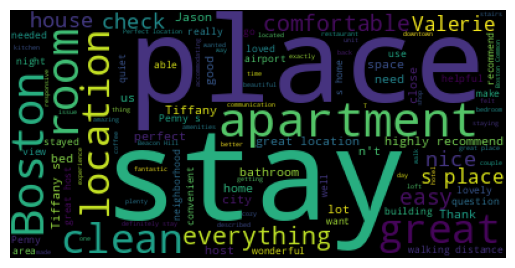

In [12]:
text3 = ' '.join(train_df['Text'])
wordcloud2 = WordCloud().generate(text3)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [13]:


## change the labels to integers for the training phase
train_df['Sentiment'][train_df["Sentiment"] == 'Negative'] = 0
train_df['Sentiment'][train_df["Sentiment"] == 'Positive'] = 1
train_df['Sentiment'][train_df["Sentiment"] == 'Mixed'] = 2



In [14]:
## change the labels to integers for the training phase
test_df['Sentiment'][test_df["Sentiment"] == 'Negative'] = 0
test_df['Sentiment'][test_df["Sentiment"] == 'Positive'] = 1
test_df['Sentiment'][test_df["Sentiment"] == 'Mixed'] = 2



In [15]:
## change the labels to integers for the training phase
val_df['Sentiment'][val_df["Sentiment"] == 'Negative'] = 0
val_df['Sentiment'][val_df["Sentiment"] == 'Positive'] = 1
val_df['Sentiment'][val_df["Sentiment"] == 'Mixed'] = 2



In [16]:

train_df

,Text,Aspect,Sentiment
0,Valerie and Jason are wonderful host ! Great p...,place--Location,1
1,Valerie and Jason are wonderful host ! Great p...,place,1
2,Valerie and Jason are wonderful host ! Great p...,place--Jason,1
3,Valerie and Jason are wonderful host ! Great p...,place--Valerie,1
4,My girlfriend and I stayed in Tiffany 's apart...,place--bathroom--Shower pressure,1
...,...,...,...
2368,Terry 's place is in a wonderful building and ...,Terry 's place--coffee pot--coffee,0
2369,Terry 's place is in a wonderful building and ...,Terry 's place--building,1
2370,By far one of the best locations you could sta...,condo--Gloria,1
2371,By far one of the best locations you could sta...,condo,1


<Axes: >

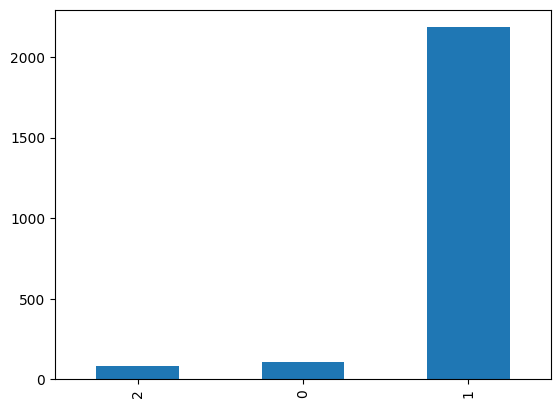

In [17]:
# Polarities distribution in our dataset
train_df.Sentiment.value_counts().sort_values().plot(kind = 'bar')


In [18]:
## Convert polarity Values to Integers
train_df["Sentiment"] = pd.to_numeric(train_df["Sentiment"],errors='coerce')


In [19]:
## Split the Dataset into Training and Testing Datasets
#X_train, y_train= train_test_split(train_df,train_df['polarity'],stratify=train_df['polarity'])

X_train  = train_df
y_train = train_df['Sentiment']

In [20]:
# the size of the training dataset
X_train.Text.size

2373

In [21]:
# Display the shape of the target values!
y_train.shape

(2373,)

In [22]:


X_test = test_df

In [23]:
## Convert polarity Values to Integers
X_test["Sentiment"] = pd.to_numeric(X_test["Sentiment"],errors='coerce')


<Axes: >

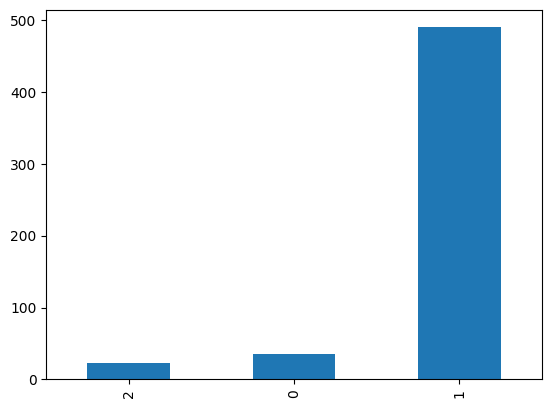

In [24]:
# Polarities distribution in our dataset
X_test.Sentiment.value_counts().sort_values().plot(kind = 'bar')

In [25]:
y_test = X_test["Sentiment"]

In [26]:
X_val = val_df

In [27]:

## Convert polarity Values to Integers
X_val["Sentiment"] = pd.to_numeric(X_val["Sentiment"],errors='coerce')


<Axes: >

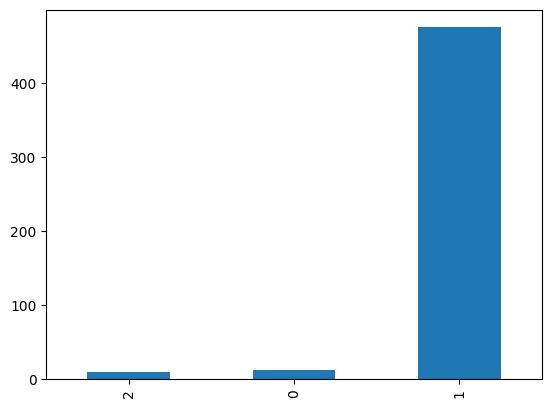

In [28]:
X_val.Sentiment.value_counts().sort_values().plot(kind = 'bar')

In [29]:
y_val = X_val["Sentiment"]

In [30]:
NUM_WORDS = 100000 ## MAx of words to keep, based on word frequency.
EMBEDDING_SIZE = 128 ## the length of the Vector the will

## Embedding code

In [31]:
tokenizer = Tokenizer(num_words=NUM_WORDS,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True, )
## Fit_on_texts : Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(list(X_train.Text))
text_X_train_tokenized = tokenizer.texts_to_sequences(X_train.Text) # list of tokenized sentences
Aspect_X_train_tokenized = tokenizer.texts_to_sequences(X_train['Aspect']) # list of tokenized sentences
text_X_test_tokenized = tokenizer.texts_to_sequences(X_test.Text) # list of tokenized sentences
Aspect_X_test_tokenized = tokenizer.texts_to_sequences(X_test['Aspect']) # list of tokenized sentences
text_X_val_tokenized = tokenizer.texts_to_sequences(X_val.Text) # list of tokenized sentences
Aspect_X_val_tokenized = tokenizer.texts_to_sequences(X_val['Aspect']) # list of tokenized sentences

In [32]:
##Maximum length of sentences
Max_Len =  max([len(one_title) for one_title in text_X_train_tokenized])
Max_Len

513

In [33]:
## Pads sequences(or sentences) to the same length.


text_X_train_padded = pad_sequences(text_X_train_tokenized, maxlen=Max_Len)
aspect_X_train_padded = pad_sequences(Aspect_X_train_tokenized, maxlen=1)

text_X_test_padded = pad_sequences(text_X_test_tokenized, maxlen=Max_Len)
aspect_X_test_padded = pad_sequences(Aspect_X_test_tokenized, maxlen=1)

text_X_val_padded = pad_sequences(text_X_val_tokenized, maxlen=Max_Len)
aspect_X_val_padded = pad_sequences(Aspect_X_val_tokenized, maxlen=1)


In [34]:
## the embedding presentation of the aspects
aspect_X_train_padded[0]

array([17], dtype=int32)

In [35]:
## the embedding presentation of the Sentences

text_X_train_padded[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [36]:
## Concatenate the Embedding presentation of the sentences and aspects to Create training and testing dataset
train_data =  [text_X_train_padded,aspect_X_train_padded]
test_data =   [text_X_test_padded,aspect_X_test_padded]
val_data = [text_X_val_padded,aspect_X_val_padded]

In [37]:
print(val_data[0].shape)

(498, 513)


## Attention Mechanism

In [38]:

# modified based on `https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2`
class Attention(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
 e: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self, W_regularizer=None, u_regularizer=None, b_regularizer=None, W_constraint=None,
                 u_constraint=None, b_constraint=None, use_W=True, use_bias=False, return_self_attend=False,
                 return_attend_weight=True, **kwargs):
        self.supports_masking = True

        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.use_W = use_W
        self.use_bias = use_bias
        self.return_self_attend = return_self_attend    # whether perform self attention and return it
        self.return_attend_weight = return_attend_weight    # whether return attention weight
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        if self.use_W:
            self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),  initializer=self.init,
                                     name='{}_W'.format(self.name), regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)
        if self.use_bias:
            self.b = self.add_weight(shape=(input_shape[1],), initializer='zero', name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer, constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],), initializer=self.init, name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer, constraint=self.u_constraint)

        super(Attention, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        if self.use_W:
            x = K.tanh(K.dot(x, self.W))

        ait = Attention.dot_product(x, self.u)
        if self.use_bias:
            ait += self.b

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        if self.return_self_attend:
            attend_output = K.sum(x * K.expand_dims(a), axis=1)
            if self.return_attend_weight:
                return [attend_output, a]
            else:
                return attend_output
        else:
            return a

    def compute_output_shape(self, input_shape):
        if self.return_self_attend:
            if self.return_attend_weight:
                return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[1])]
            else:
                return input_shape[0], input_shape[-1]
        else:
            return input_shape[0], input_shape[1]

    @staticmethod
    def dot_product(x, kernel):
        """
        Wrapper for dot product operation, in order to be compatible with both
        Theano and Tensorflow
        Args:
            x (): input
            kernel (): weights
        Returns:
        """
        if K.backend() == 'tensorflow':
            return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
        else:
            return K.dot(x, kernel)

## LSTM with Aspect Embedding

In [39]:
def ae_lstm(lstm_units = 512):
    input_text = Input(shape=(Max_Len,))
    input_aspect = Input(shape=(1,),)

    word_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
    text_embed = SpatialDropout1D(0.2)(word_embedding(input_text))

    asp_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
    aspect_embed = asp_embedding(input_aspect)


    aspect_embed = Flatten()(aspect_embed)  # reshape to 2d
    repeat_aspect = RepeatVector(Max_Len)(aspect_embed)  # repeat aspect for every word in sequence

    input_concat = concatenate([text_embed, repeat_aspect], axis=-1)
    hidden = LSTM(lstm_units)(input_concat)
    Dense_layer  = Dense(128, activation='relu')(hidden)
    output_layer = Dense(3, activation='softmax')(Dense_layer)
    return Model([input_text, input_aspect], output_layer)

In [40]:
ae_lstm_model = ae_lstm()
ae_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 513)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 128)               1280000   ['input_2[0][0]']             
                                                          0                                       
                                                                                                  
 embedding (Embedding)       (None, 513, 128)             1280000   ['input_1[0][0]']         

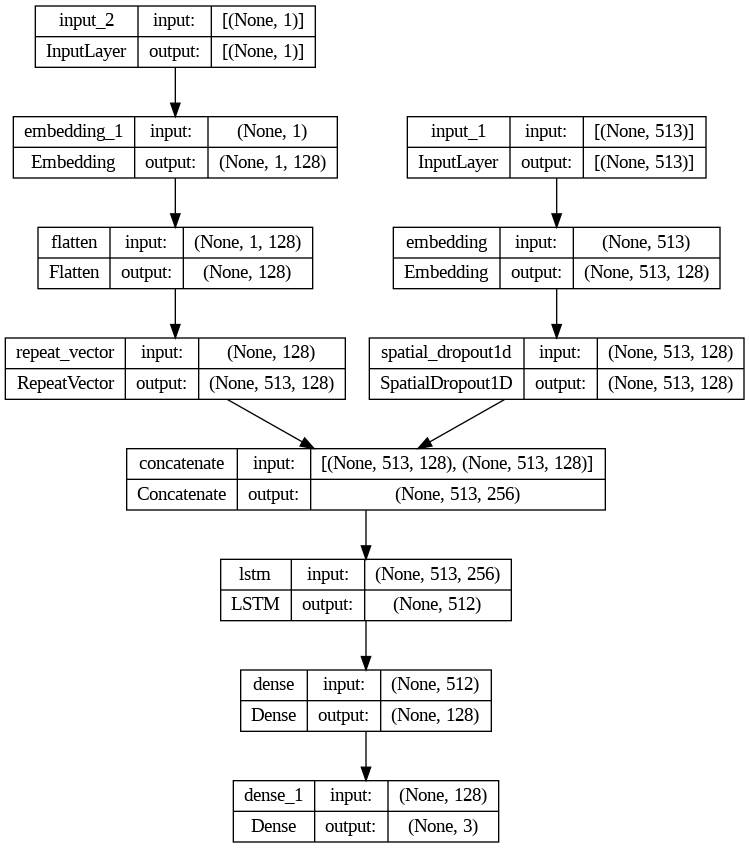

In [41]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(ae_lstm_model, to_file=dot_img_file, show_shapes=True)


In [42]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                    patience = 2,
                                                    verbose=1,
                                                    factor=0.1,
                                                    min_lr=0.000001)
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.01)

ae_lstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
checkpoint = ModelCheckpoint('Models/DOTSA_HOTELS_AE-LSTM.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history =  ae_lstm_model.fit(x = train_data, y = y_train, validation_data = (val_data, y_val), batch_size=16, epochs=5, callbacks = [learning_rate_reduction,checkpoint])

Epoch 1/5
149/149 [==============================] - ETA: 0s - loss: 0.3612 - accuracy: 0.9128
Epoch 1: val_accuracy improved from -inf to 0.94980, saving model to Models/DOTSA_HOTELS_AE-LSTM.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


149/149 [==============================] - 52s 243ms/step - loss: 0.3612 - accuracy: 0.9128 - val_loss: 0.2267 - val_accuracy: 0.9498 - lr: 0.0100
Epoch 2/5
149/149 [==============================] - ETA: 0s - loss: 0.2909 - accuracy: 0.9300
Epoch 2: val_accuracy did not improve from 0.94980
149/149 [==============================] - 19s 131ms/step - loss: 0.2909 - accuracy: 0.9300 - val_loss: 0.3017 - val_accuracy: 0.9277 - lr: 0.0100
Epoch 3/5
149/149 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9456
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 3: val_accuracy did not improve from 0.94980
149/149 [==============================] - 17s 117ms/step - loss: 0.1736 - accuracy: 0.9456 - val_loss: 0.3517 - val_accuracy: 0.9297 - lr: 0.0100
Epoch 4/5
149/149 [==============================] - ETA: 0s - loss: 0.1324 - accuracy: 0.9553
Epoch 4: val_accuracy did not improve from 0.94980
149/149 [==============================] - 1

##Model evaluation

In [43]:
print("Evaluate on test data")
results = ae_lstm_model.evaluate(x = test_data , y = y_test )
print("test loss, test acc:", results)
print("Accuracy of the model is - " , results[1]*100 , "%")

Evaluate on test data
18/18 [==============================] - 1s 36ms/step - loss: 0.5388 - accuracy: 0.8798
test loss, test acc: [0.5387987494468689, 0.8797814249992371]
Accuracy of the model is -  87.9781424999237 %


##save results

In [44]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming atae_lstm_model.predict returns the predicted probabilities for your test data
y_pred_probs = ae_lstm_model.predict(test_data)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Assuming y_test is the true labels for your test data
y_true_classes = np.array(y_test)  # Assuming y_test is already in the correct format

# Print the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


18/18 [==============================] - 1s 29ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.22      0.31        36
           1       0.91      0.97      0.94       490
           2       0.12      0.09      0.10        23

    accuracy                           0.88       549
   macro avg       0.52      0.42      0.45       549
weighted avg       0.86      0.88      0.86       549



In [45]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f_score = f1_score(y_true_classes, y_pred_classes, average='weighted')


data_to_append = {
        'dataset_name': "DOTSA_Hotels",
        'task':"ATSA",
        'test_accuracy': round(results[1]*100,2),
        'f_score': round(f_score*100, 2),
        'recall': round(recall*100,2),
        'precision': round(precision*100,2)
}

csv_file = "/content/drive/MyDrive/ABSA work/Results LSTM/ATSA/ATSA_Results/"+"Results_ae.csv"  # Replace with your CSV file name
df = pd.DataFrame(columns=['dataset_name', 'task', 'test_accuracy', 'f_score', 'precision', 'recall'])


# Load existing data from CSV file into DataFrame
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    # If the file doesn't exist, create a new DataFrame
    df = pd.DataFrame(columns=['dataset_name', 'task', 'test_accuracy', 'f_score', 'precision', 'recall'])




df = df.append(data_to_append, ignore_index=True)
df.to_csv(csv_file, index=False)

<ipython-input-45-48a3d6ad9aa5>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_to_append, ignore_index=True)


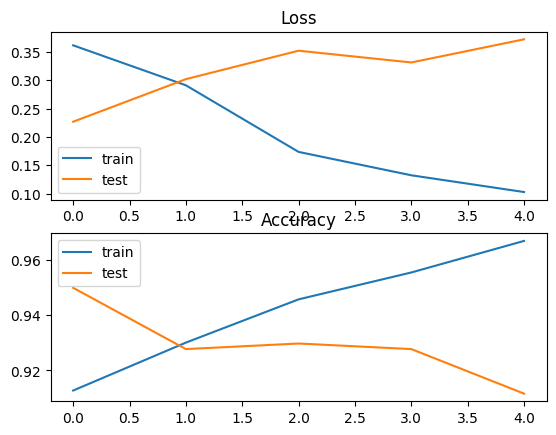

In [46]:

from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


##  Attention-based LSTM (AT-LSTM)

In [47]:
def at_lstm(lstm_units = 512):
        input_text = Input(shape=(Max_Len,))
        input_aspect = Input(shape=(1,),)

        word_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
        text_embed = SpatialDropout1D(0.2)(word_embedding(input_text))

        asp_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
        aspect_embed = asp_embedding(input_aspect)
        aspect_embed = Flatten()(aspect_embed)  # reshape to 2d
        repeat_aspect = RepeatVector(Max_Len)(aspect_embed)  # repeat aspect for every word in sequence
        hidden_vecs = LSTM(lstm_units, return_sequences=True)(text_embed)  # hidden vectors output by lstm
        concat = concatenate([hidden_vecs, repeat_aspect], axis=-1)  # mask after concatenate will be same as hidden_out's mask
        print(concat.shape)
         # apply attention mechanism
        attend_weight = Attention()(concat)
        attend_weight_expand = Lambda(lambda x: K.expand_dims(x))(attend_weight)
        attend_hidden = multiply([hidden_vecs, attend_weight_expand])
        attend_hidden = Lambda(lambda x: K.sum(x, axis=1))(attend_hidden)
        Dense_layer  = Dense(128, activation='relu')(attend_hidden)
        output_layer = Dense(3, activation='softmax')(Dense_layer)
        return Model([input_text, input_aspect], output_layer)

In [48]:
at_lstm_model =  at_lstm()
at_lstm_model.summary()

(None, 513, 640)


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 513)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 513, 128)             1280000   ['input_3[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 128)               1280000   ['input_4[0][0]']       

## model training


In [49]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                    patience = 2,
                                                    verbose=1,
                                                    factor=0.1,
                                                    min_lr=0.000001)
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.01)


at_lstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
checkpoint = ModelCheckpoint('Models/DOTSA_HOTELS_AT-LSTM.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history =  at_lstm_model.fit(x = train_data, y = y_train, validation_data = (val_data, y_val), batch_size=16, epochs=5, callbacks = [learning_rate_reduction,checkpoint])

Epoch 1/5
149/149 [==============================] - ETA: 0s - loss: 0.4026 - accuracy: 0.9107
Epoch 1: val_accuracy improved from -inf to 0.95382, saving model to Models/DOTSA_HOTELS_AT-LSTM.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


149/149 [==============================] - 32s 190ms/step - loss: 0.4026 - accuracy: 0.9107 - val_loss: 0.2181 - val_accuracy: 0.9538 - lr: 0.0100
Epoch 2/5
149/149 [==============================] - ETA: 0s - loss: 0.3079 - accuracy: 0.9199
Epoch 2: val_accuracy did not improve from 0.95382
149/149 [==============================] - 20s 134ms/step - loss: 0.3079 - accuracy: 0.9199 - val_loss: 0.1747 - val_accuracy: 0.9538 - lr: 0.0100
Epoch 3/5
149/149 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.9275
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 3: val_accuracy did not improve from 0.95382
149/149 [==============================] - 17s 113ms/step - loss: 0.2217 - accuracy: 0.9275 - val_loss: 0.2109 - val_accuracy: 0.9538 - lr: 0.0100
Epoch 4/5
149/149 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9393
Epoch 4: val_accuracy did not improve from 0.95382
149/149 [==============================] - 1

## Model Evaluation

In [50]:
#val_data =   [text_X_test_padded[6].reshape(1,Max_Len),aspect_X_test_padded[6]]
#at_lstm_model.predict(val_data)

In [51]:
print("Evaluate on test data")
results = at_lstm_model.evaluate(x = test_data , y = y_test )
print("test loss, test acc:", results)
print("Accuracy of the model is - " , results[1]*100 , "%")

Evaluate on test data
18/18 [==============================] - 1s 39ms/step - loss: 0.2769 - accuracy: 0.9016
test loss, test acc: [0.2768971920013428, 0.9016393423080444]
Accuracy of the model is -  90.16393423080444 %


##save results

In [52]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming atae_lstm_model.predict returns the predicted probabilities for your test data
y_pred_probs = at_lstm_model.predict(test_data)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Assuming y_test is the true labels for your test data
y_true_classes = np.array(y_test)  # Assuming y_test is already in the correct format

# Print the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


18/18 [==============================] - 1s 31ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.47      0.47        36
           1       0.93      0.98      0.95       490
           2       0.00      0.00      0.00        23

    accuracy                           0.90       549
   macro avg       0.47      0.48      0.48       549
weighted avg       0.86      0.90      0.88       549



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f_score = f1_score(y_true_classes, y_pred_classes, average='weighted')


data_to_append = {
        'dataset_name': "DOTSA_Hotels",
        'task':"ATSA",
        'test_accuracy': round(results[1]*100,2),
        'f_score': round(f_score*100, 2),
        'recall': round(recall*100,2),
        'precision': round(precision*100,2)
}

csv_file = "/content/drive/MyDrive/ABSA work/Results LSTM/ATSA/ATSA_Results/"+"Results_at.csv"  # Replace with your CSV file name
df = pd.DataFrame(columns=['dataset_name', 'task', 'test_accuracy', 'f_score', 'precision', 'recall'])


# Load existing data from CSV file into DataFrame
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    # If the file doesn't exist, create a new DataFrame
    df = pd.DataFrame(columns=['dataset_name', 'task', 'test_accuracy', 'f_score', 'precision', 'recall'])




df = df.append(data_to_append, ignore_index=True)
df.to_csv(csv_file, index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-53-979d66b6b573>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_to_append, ignore_index=True)


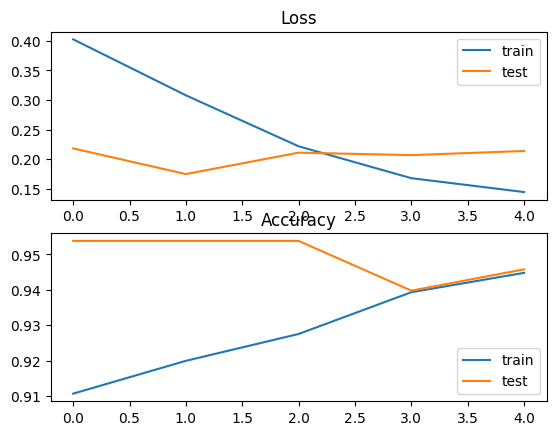

In [54]:

from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


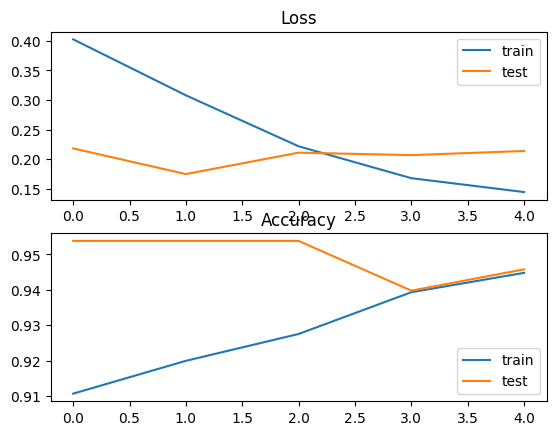

In [55]:

from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


## Attention-based LSTM with Aspect Embedding (ATAE-LSTM)

In [ ]:
# attention-based lstm with aspect embedding
def atae_lstm(lstm_units = 128):
    input_text = Input(shape=(Max_Len,))
    input_aspect = Input(shape=(1,),)

    word_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
    text_embed = SpatialDropout1D(0.2)(word_embedding(input_text))

    asp_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)

    aspect_embed = asp_embedding(input_aspect)
    aspect_embed = Flatten()(aspect_embed)  # reshape to 2d
    repeat_aspect = RepeatVector(Max_Len)(aspect_embed)  # repeat aspect for every word in sequence

    input_concat = concatenate([text_embed, repeat_aspect], axis=-1)
    print(input_concat.shape)
    hidden_vecs, state_h, _ = LSTM(lstm_units, return_sequences=True, return_state=True)(input_concat)
    concat = concatenate([hidden_vecs, repeat_aspect], axis=-1)

    # apply attention mechanism
    attend_weight = Attention()(concat)
    attend_weight_expand = Lambda(lambda x: K.expand_dims(x))(attend_weight)
    attend_hidden = multiply([hidden_vecs, attend_weight_expand])
    attend_hidden = Lambda(lambda x: K.sum(x, axis=1))(attend_hidden)

    attend_hidden_dense = Dense(lstm_units)(attend_hidden)
    last_hidden_dense = Dense(lstm_units)(state_h)
    final_output = Activation('tanh')(add([attend_hidden_dense, last_hidden_dense]))

    output = Dense(3, activation='softmax')(final_output)

    return Model([input_text, input_aspect], output)

In [ ]:
atae_lstm_model =  atae_lstm()
atae_lstm_model.summary()

(None, 513, 256)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 513)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 1, 128)               1280000   ['input_6[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_4 (Embedding)     (None, 513, 128)             1280000   ['input

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


## Model Training

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                    patience = 2,
                                                    verbose=1,
                                                    factor=0.1,
                                                    min_lr=0.000001)
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.01)

atae_lstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
checkpoint = ModelCheckpoint('Models/DOTSA_HOTELS_ATAE-LSTM.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
history =  atae_lstm_model.fit(x = train_data, y = y_train, validation_data = (val_data, y_val), batch_size=16, epochs=5, callbacks = [learning_rate_reduction,checkpoint])

Epoch 1/5
149/149 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.9153
Epoch 1: val_accuracy improved from -inf to 0.95382, saving model to Models/DOTSA_HOTELS_ATAE-LSTM.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


149/149 [==============================] - 25s 143ms/step - loss: 0.4210 - accuracy: 0.9153 - val_loss: 0.2185 - val_accuracy: 0.9538 - lr: 0.0100
Epoch 2/5
149/149 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.9250
Epoch 2: val_accuracy did not improve from 0.95382
149/149 [==============================] - 14s 91ms/step - loss: 0.2907 - accuracy: 0.9250 - val_loss: 0.2050 - val_accuracy: 0.9498 - lr: 0.0100
Epoch 3/5
149/149 [==============================] - ETA: 0s - loss: 0.2435 - accuracy: 0.9296
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 3: val_accuracy did not improve from 0.95382
149/149 [==============================] - 10s 65ms/step - loss: 0.2435 - accuracy: 0.9296 - val_loss: 0.2590 - val_accuracy: 0.9458 - lr: 0.0100
Epoch 4/5
149/149 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.9482
Epoch 4: val_accuracy did not improve from 0.95382
149/149 [==============================] - 7s 

## Model Evaluation

In [ ]:
print("Evaluate on test data")
results = atae_lstm_model.evaluate(x = test_data , y = y_test )
print("test loss, test acc:", results)
print("Accuracy of the model is - " , results[1]*100 , "%")

Evaluate on test data
18/18 [==============================] - 0s 18ms/step - loss: 0.4364 - accuracy: 0.8834
test loss, test acc: [0.43636661767959595, 0.8834244012832642]
Accuracy of the model is -  88.34244012832642 %


##save results

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming atae_lstm_model.predict returns the predicted probabilities for your test data
y_pred_probs = atae_lstm_model.predict(test_data)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Assuming y_test is the true labels for your test data
y_true_classes = np.array(y_test)  # Assuming y_test is already in the correct format

# Print the classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


18/18 [==============================] - 1s 10ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.19      0.29        36
           1       0.90      0.98      0.94       490
           2       0.00      0.00      0.00        23

    accuracy                           0.88       549
   macro avg       0.50      0.39      0.41       549
weighted avg       0.84      0.88      0.86       549



In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f_score = f1_score(y_true_classes, y_pred_classes, average='weighted')


data_to_append = {
        'dataset_name': "DOTSA_Hotels",
        'task':"ATSA",
        'test_accuracy': round(results[1]*100,2),
        'f_score': round(f_score*100, 2),
        'recall': round(recall*100,2),
        'precision': round(precision*100,2)
}

csv_file = "/content/drive/MyDrive/ABSA work/Results LSTM/ATSA/ATSA_Results/"+"Results_atae.csv"  # Replace with your CSV file name
df = pd.DataFrame(columns=['dataset_name', 'task', 'test_accuracy', 'f_score', 'precision', 'recall'])


# Load existing data from CSV file into DataFrame
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    # If the file doesn't exist, create a new DataFrame
    df = pd.DataFrame(columns=['dataset_name', 'task', 'test_accuracy', 'f_score', 'precision', 'recall'])




df = df.append(data_to_append, ignore_index=True)
df.to_csv(csv_file, index=False)

<ipython-input-63-f718a4d2722f>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_to_append, ignore_index=True)


PREDICT SENTENCE

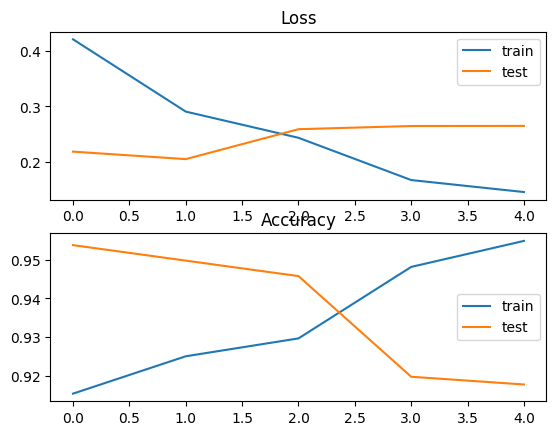

In [ ]:

from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()
